In [1]:
import numpy as np
import cmath
import math
import matplotlib.pyplot as plt 

In [2]:
def despreader(Tss_, gold, M=1): 
    #Input: Spread spectrum sequence, gold sequence, value of M
    #Output: Despread list of recieved symbols
    
    #Function first multiplies input by the gold sequence to remove it
    #Followed by averaging every M symbols and appending to symbols
    symbols = []
    
    for i in range(len(Tss_)):
        Tss_[i] = Tss_[i] * gold[i%len(gold)]
        
    while len(Tss_) != 0:
        symbol = sum(Tss_[:M])/M
        symbols.append(symbol)
        Tss_ = Tss_[M:]
    return symbols

In [3]:
def channel(T, SNRin = None, jammer = None):
    #Input: list of symbols, noise SNRin, jamming signal
    #Output: list of symbols
    
    #If noise is to be added, linear ratio of noise is calculated then noise added to each sampl
    #If a jammer is present, the jamming message is summed to each of the samples
    if SNRin is not None:
        Ps = signalPower(T)
        SNRlin = 10**(SNRin/10)
        Pn = Ps/SNRlin
        T = [t + complex(np.random.normal(scale = math.sqrt(Pn)), np.random.normal(scale = math.sqrt(Pn))) for t in T]
    
    if jammer is not None:
        T = [t+i for t, i in list(zip(T, jammer))]
    return T

def signalPower(T):
    summation = 0
    for i in T:
        summation += (abs(i))**2
    return summation/len(T)

In [4]:
def errorCount(Rx, Tx, percent = False):
    #Input: Two recieved messages (in text format), value of whether to return as a percent or a proportion
    #Output: either proportion or percentage
    
    #Formats messages into binary and joins them into a single string
    #Then iterates through each value and counts how often 2 messages don't match
    Rx = ''.join(sourceEncoder(Rx))
    Tx = ''.join(sourceEncoder(Tx))
    errorCount = 0
    for r, t in list(zip(Rx, Tx)):
        if r != t:
            errorCount += 1
    if percent:
        return errorCount / len(Rx)
    else:
        return errorCount

In [5]:
def spreader(T, gold, M = 1):
    #Input: Message, gold sequence, value of M
    #Output: Spread message
    
    #Extends signal by factor M (ie, M repititions of each sample)
    #Multiplies by gold sequence
    output = np.repeat(T, M)
    for i in range(len(output)):
        output[i] = output[i] * gold[i%len(gold)]
    
    return output  

In [22]:
def generateGold(polynomials, offset=0):
    #Input: tuple of 2 polynomials, offset to be used
    #Output: gold sequence
    PN1 = PN(polynomials[0])
    PN2 = PN(polynomials[1])
    delayedSequence = PN2[-offset:] + PN2[0:-offset]
    gold = [1-2*((i + j)%2) for i, j in list(zip(PN1, delayedSequence))]    
    return gold

In [7]:
def isbalanced(polynomials, offset):
    gold = generateGold(polynomials, offset)
    track1=0
    trackneg1=0
    for i in gold:
        if i == 1:
            track1+=1
        else:
            trackneg1+=1
    if track1 == trackneg1-1:
        print('Balanced')
    else:
        print('Unbalanced')
        print(track1)
        print(trackneg1)
    

In [8]:
def PN(polynomial): 
    #Input: single polynomial list
    #Output: PN sequence
    
    #creates up an initial setting of all 1s in LFSR, repeats updates until state is again equal to initial value
    PN = [1]  
    initial = [1] * max(polynomial) 
    state = [1] * max(polynomial) 
    polynomial = polynomial[1:] 
    polynomial = [i + 1 for i in polynomial] 

    while True:
        new = state[-1]
        for i in polynomial:
            new += state[-i]
        new = new % 2
        state.insert(0, new)
        state.pop(-1)
        if state == initial: break
        PN.append(state[-1])
        
    return PN

In [9]:
def sourceDecoder(B_):
    #Input: list of binary symbols
    #Output: message string
    charactersBinary = [''.join([a,b,c,d]) for a, b, c, d in list(zip(B_[0::4], B_[1::4], B_[2::4], B_[3::4], ))]
    characters = [chr(int(character, 2)) for character in charactersBinary]
    
    return ''.join(characters)
    
    

In [10]:
def digitalDemodulator(T_):
    #Input: list of symbols
    #Output: list of binary symbols
    
    #maps symbols to binary values by checking the phase and comparing 
    B_ = []
    for t in T_:
        p = cmath.phase(t)
        if p <= math.radians(88) and p > math.radians(-2):
            B_.append('00')
        elif p <= math.radians(-2) and p > math.radians(-92):
            B_.append('10')
        elif p <= math.radians(178) and p > math.radians(88):
            B_.append('01')
        elif (p <= math.radians(180) and p > math.radians(178)) or (p <= math.radians(-92) and p >= math.radians(-180)):
            B_.append('11')
    return B_
        

In [11]:
def digitalModulator(B, phi = cmath.pi/4, relativePower = 1):
    T = []
    symbols = {"00":cmath.rect(math.sqrt(2*relativePower), phi), 
               "01":cmath.rect(math.sqrt(2*relativePower), phi + cmath.pi/2),
               "11":cmath.rect(math.sqrt(2*relativePower), phi + cmath.pi),
               "10":cmath.rect(math.sqrt(2*relativePower), phi + (3*cmath.pi)/2)
               }
    for i in B:
        T.append(symbols[i[0:2]])
        T.append(symbols[i[2:4]])
        T.append(symbols[i[4:6]])
        T.append(symbols[i[6:8]])
    return(T)
            

In [12]:
def sourceEncoder(message):
    #Creates a list of 8 digit binary characters for the message returns as a list of strings
    integers = [ord(character) for character in message]
    return ['{0:08b}'.format(integer) for integer in integers]

In [13]:
def plotConstellation(symbols, save):
    t_real = [i.real for i in symbols]
    t_imag = [i.imag for i in symbols]
    plt.scatter(t_real, t_imag)
    plt.xlabel('Re')
    plt.ylabel('Im')
    if save is not False:
        plt.savefig(save)

In [14]:
def run(M=None, SNR=None, SNRj=None, plot = False, save=False):
    B = sourceEncoder(A)
    T = digitalModulator(B, phi)
    
    jammer = None
    if SNRj != None:
        SNRjlin = 10**(SNRj/10)
        encodedInterference = sourceEncoder(interference)
        modulatedInterference = digitalModulator(encodedInterference, relativePower = SNRjlin)
        
        if M != None:
            goldJ = generateGold(polynomialsJ, offset)
            jammer = spreader(modulatedInterference, goldJ, M = M)
        else:
            jammer = modulatedInterference
    
    
    if M != None:
        gold = generateGold(polynomials, offset)
        
        Tss = spreader(T, gold, M = M)
        
        Tss_ = channel(Tss, SNRin = SNR, jammer = jammer)
        
        T_ = despreader(Tss_, gold, M = M)
    else:
        T_ = channel(T, SNRin = SNR, jammer = jammer)
        
    
    B_ = digitalDemodulator(T_)
    
    A_ = sourceDecoder(B_)
        
    if plot:
        plotConstellation(T_, save)
        print(A_ + '\n')
        print(str( errorCount(A_, A, percent=True) * 100) + "%")
    bitErrorCount = errorCount(A_, A)
    return bitErrorCount
        

In [15]:
#Message and interference are randomly generated Lorem Ipsum text, both of 300 characters
A = str(open("../message.txt","r").read())
interference = str(open("../noise.txt", "r").read())
#phi = alphabetical order of 1st letter of surname + 2x alphabetical order of 1st letter of surname
#phi = 5 + 2(19) = 43
phi = math.radians(43) #in radians

PN1 = [5,2]
PN2 = [5,3,2,1]
polynomials = (PN1, PN2)
offset = 24

PN1J = [5,3]
PN2J = [5,4,2,1]
polynomialsJ = (PN1J, PN2J)

Task 1

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Suspendisse non orci sem. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Maecenas tempor et urna sit amet ornare. Maecenas mattis ligula eleifend, ultrices lacus a, pellentesque nisl. Vestibulum tel

0.0%


0

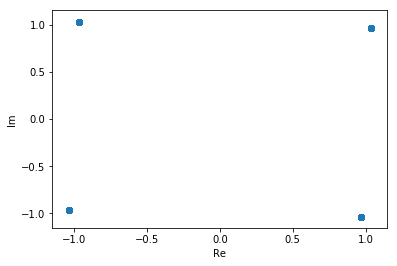

In [25]:
run(plot = True)

Task 2

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Suspendisse non orci sem. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Maecenas tempor et urna sit amet ornare. Maecenas mattis ligula eleifend, ultrices lacus a, pellentesque nisl. Vestibulum tel

0.0%


0

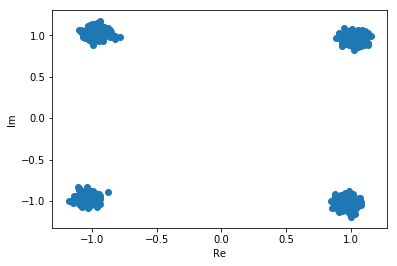

In [26]:
run(SNR = 30, plot = True)

Task 3

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Suspendisse non orci sem. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Maecenas tempor et urna sit amet ornare. Maecenas mattis ligula eleifend, ultrices lacus a, pellentesque nisl. Vestibulum tel

0.0%


0

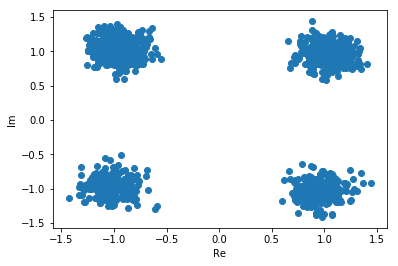

In [27]:
run(SNR =  20, plot = True)

Task 4

&ñnu=)`m|

23.166666666666664%


556

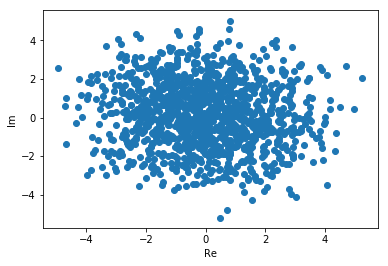

In [28]:
run(SNR = 0, plot = True)

Task 6

Mauris interdum tempor neque, eget ornare erat eleifend luctus. In quis arcu cursus, lobortis leo sit amet, dignissim odio. Mauris molestie vel orci et consequat. Nunc nec sapien eu purus tempor vulputate. Donec in tristique lectus, a interdum orci. Cras rhoncus sapien nec aliquet egestas. Donec ege

33.08333333333333%


794

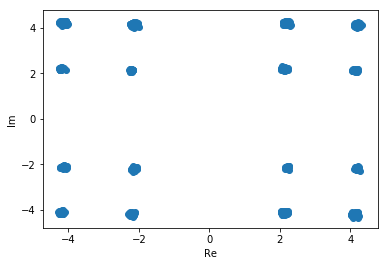

In [29]:
run(SNR = 30, SNRj = 10, plot = True)

Task 7

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Suspendisse non orci sem. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Maecenas tempor et urna sit amet ornare. Maecenas mattis ligula eleifend, ultrices lacus a, pellentesque nisl. Vestibulum tel

0.0%


0

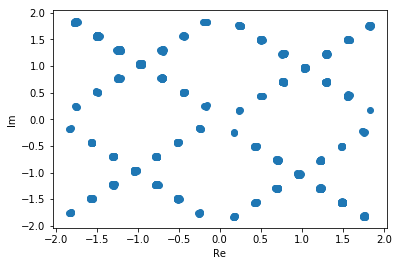

In [38]:
run(SNR = 30, SNRj = 10, M = 24, plot = True)
#run(SNR = 30, SNRj = 10, M = 30, plot = True)
#run(SNR = 30, SNRj = 10, M = 10, plot = True)